In [12]:
import pandas as pd

pd.set_option("display.max_columns", None)  # Toont alle kolommen
pd.set_option("display.width", 100)  # Voorkomt afkapping van kolommen
pd.set_option("display.max_rows", 1400)  # Beperkt aantal rijen om overzichtelijk te blijven

In [13]:
df_Full_dataset = pd.read_csv('TEG_Data&Weather_2Years_WithNAN.csv')

In [ ]:
import pandas as pd

df = df_Full_dataset

df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Month'] = df['Timestamp'].dt.month

In [ ]:
import numpy as np
import pandas as pd

df = df_Full_dataset.copy()
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.set_index("Timestamp").sort_index()

df["Energy_lag_1"] = df["Energy (J)"].shift(1)
df["Energy_lag_2"] = df["Energy (J)"].shift(2)
df["Moving_average_energy_3"] = df["Energy (J)"].shift(1).rolling(window=3).mean()

df["Direct_radiation_lag_1"] = df["direct_rad:W"].shift(1)
df["Direct_radiation_lag_2"] = df["direct_rad:W"].shift(2)
df["Moving_average_direct_radiation_3"] = df["direct_rad:W"].shift(1).rolling(window=3).mean()

df["Ambient_Temperature_lag_1"] = df["Ambient_Temperature"].shift(1)
df["Ambient_Temperature_lag_2"] = df["Ambient_Temperature"].shift(2)
df["Moving_average_Ambient_Temperature_3"] = df["Ambient_Temperature"].shift(1).rolling(window=3).mean()

df["Ground_50cm_Temperature_lag_1"] = df["Ground_50cm_Temperature"].shift(1)
df["Ground_50cm_Temperature_lag_2"] = df["Ground_50cm_Temperature"].shift(2)
df["Moving_average_Ground_50cm_Temperature_3"] = df["Ground_50cm_Temperature"].shift(1).rolling(window=3).mean()

df["Hour_direct_interaction"] = df["Hour"] * df["direct_rad:W"]

# Targets
df["Energy_sum_target_30minutes"] = df["Energy (J)"].shift(-5).rolling(window=6, min_periods=6).sum()
df["Energy_sum_target_1hour"] = df["Energy (J)"].shift(-11).rolling(window=12, min_periods=12).sum()
df["Energy_sum_target_6hours"] = df["Energy (J)"].shift(-66).rolling(window=72, min_periods=72).sum()
df["Energy_sum_target_12hours"] = df["Energy (J)"].shift(-132).rolling(window=144, min_periods=144).sum()
df["Energy_sum_target_24hours"] = df["Energy (J)"].shift(-264).rolling(window=288, min_periods=288).sum()

YEAR1 = df.loc["2022-10-01":"2023-09-30"].dropna()
YEAR2 = df.loc["2023-10-01":"2024-08-31"].dropna()



In [ ]:
import numpy as np, pandas as pd, math, warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore")

if not isinstance(df.index, pd.DatetimeIndex):
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.set_index("Timestamp").sort_index()


# 1. Features & target
features = [
    "direct_rad:W","Direct_radiation_lag_1","Direct_radiation_lag_2",
    "Moving_average_direct_radiation_3",
    "Ground_50cm_Temperature","Ground_50cm_Temperature_lag_1",
    "Ground_50cm_Temperature_lag_2","Moving_average_Ground_50cm_Temperature_3",
    "Ambient_Temperature",
    "Energy_lag_1","Energy_lag_2","Moving_average_energy_3",
    "Hour","Month",

    "precip_5min:mm",
    "dew_point_2m:C",
    "relative_humidity_2m:p",
    "visibility:m",
    "wind_dir_10m:d",
    "wind_speed_10m:ms",
    "sfc_pressure:Pa"
]

target = "Energy_sum_target_1hour"


# 3. Jaarblokken & 80-/20-split
split_ix = int(len(YEAR1) * 0.8)
train_df = YEAR1.iloc[:split_ix]
val_df   = YEAR1.iloc[split_ix:]

X_train, y_train = train_df[features], train_df[target]
X_val  , y_val   = val_df[features] , val_df[target]


# 4. Pipeline + RandomizedSearchCV (Random Forest)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ))
])

param_space = {
    "rf__n_estimators":      [20, 40, 60],
    "rf__max_depth":         [10, 20, 30],
    "rf__min_samples_split": [2, 4, 6],
    "rf__min_samples_leaf":  [1, 2, 4],
    "rf__max_features":      ["log2", "sqrt"],
}

# Predefined train/val-split uit stap 4 — dezelfde logica als bij XGB.
split_arr = np.r_[np.full(len(X_train), -1), np.zeros(len(X_val))]
ps = PredefinedSplit(split_arr)

X_search = pd.concat([X_train, X_val])
y_search = pd.concat([y_train, y_val])

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_space,
    cv=ps,
    n_iter=25,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
    random_state=42
).fit(X_search, y_search)

print("\nBeste hyperparameters:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")


# 5. Train- & validatie-scores (80-/20) met het beste model
best_model = search.best_estimator_

train_pred = best_model.predict(X_train)
val_pred   = best_model.predict(X_val)

def metr(y_true, y_pred):
    """Geef MAE, RMSE en R² terug."""
    return (
        mean_absolute_error(y_true, y_pred),
        math.sqrt(mean_squared_error(y_true, y_pred)),
        r2_score(y_true, y_pred)
    )

mae_tr, rmse_tr, r2_tr   = metr(y_train, train_pred)
mae_val, rmse_val, r2_val = metr(y_val,   val_pred)

print("\n80-/20-split resultaten")
print(f"  TRAIN  MAE {mae_tr:.3f} | RMSE {rmse_tr:.3f} | R² {r2_tr:.3f}")
print(f"  VAL    MAE {mae_val:.3f} | RMSE {rmse_val:.3f} | R² {r2_val:.3f}")


# 6. Definitief model op heel jaar 1
final_model = search.best_estimator_
final_model.fit(YEAR1[features], YEAR1[target])


# 7. Seizoens-evaluatie in jaar 2
season_blocks = [
    ("Herfst 23",   "2023-10-01", "2023-11-30"),
    ("Winter 23/24", "2023-12-01", "2024-02-29"),
    ("Lente 24",     "2024-03-01", "2024-05-31"),
    ("Zomer 24",     "2024-06-01", "2024-08-31"),
]

mae_l, rmse_l, r2_l = [], [], []
print("\nSeizoens-scores (jaar 2)")

for name, d1, d2 in season_blocks:
    block = YEAR2.loc[d1:d2]
    if block.empty:
        print(f"{name:10s} – geen rijen in deze periode")
        continue

    y_true = block[target]
    y_pred = final_model.predict(block[features])

    mae, rmse, r2 = metr(y_true, y_pred)
    mae_l.append(mae); rmse_l.append(rmse); r2_l.append(r2)

    print(f"{name:10s}  MAE {mae:.3f} | RMSE {rmse:.3f} | R² {r2:.3f}")

if mae_l:
    print("\nGemiddeld over vier seizoenen")
    print(f"  MAE  {np.mean(mae_l):.3f}")
    print(f"  RMSE {np.mean(rmse_l):.3f}")
    print(f"  R²   {np.mean(r2_l):.3f}")


Fitting 1 folds for each of 25 candidates, totalling 25 fits

Beste hyperparameters:
  rf__n_estimators: 60
  rf__min_samples_split: 6
  rf__min_samples_leaf: 2
  rf__max_features: sqrt
  rf__max_depth: 20

80-/20-split resultaten
  TRAIN  MAE 0.070 | RMSE 0.221 | R² 0.989
  VAL    MAE 0.102 | RMSE 0.307 | R² 0.990

Seizoens-scores (jaar 2)
Herfst 23   MAE 0.115 | RMSE 0.261 | R² 0.898
Winter 23/24  MAE 0.055 | RMSE 0.175 | R² 0.863
Lente 24    MAE 0.332 | RMSE 1.062 | R² 0.876
Zomer 24    MAE 0.392 | RMSE 1.123 | R² 0.892

Gemiddeld over vier seizoenen
  MAE  0.224
  RMSE 0.655
  R²   0.882


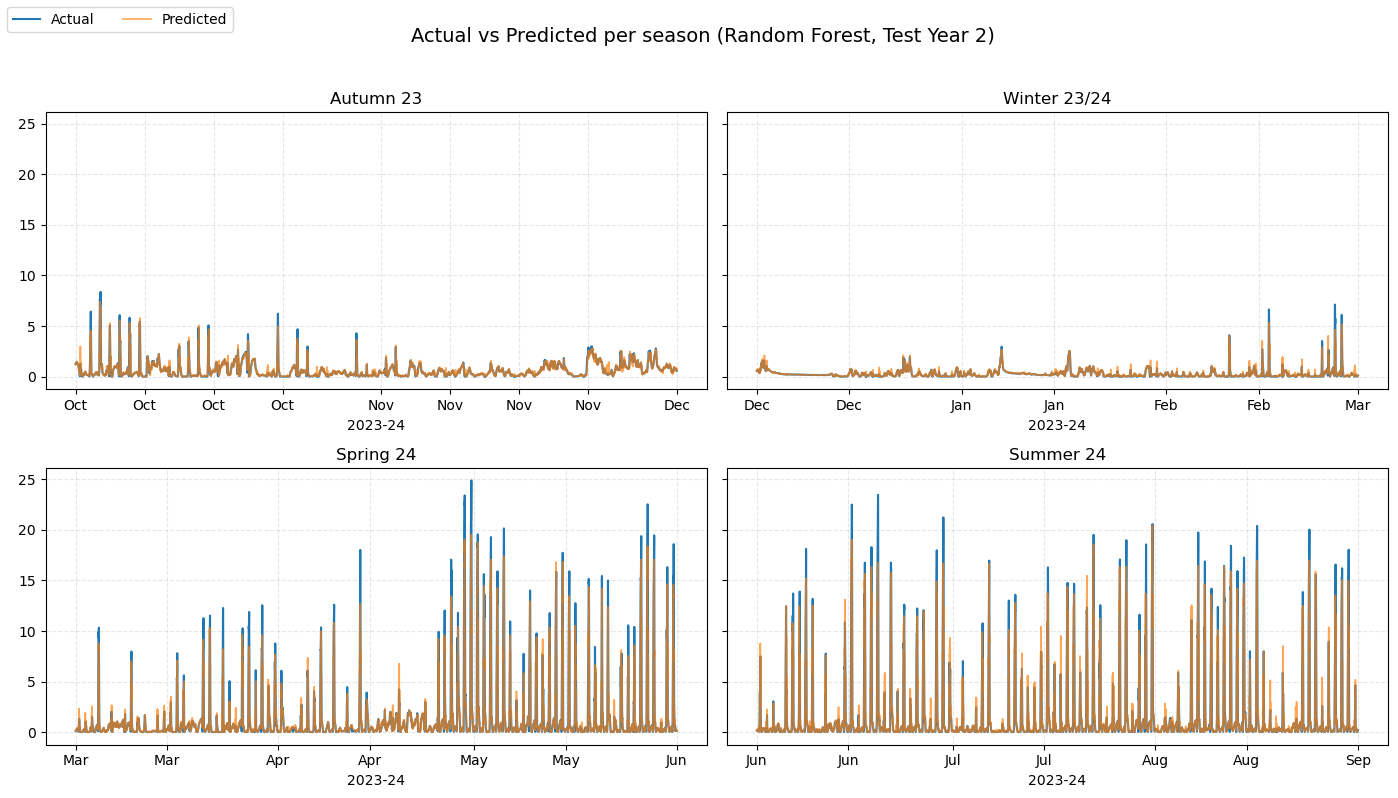

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

season_blocks_en = [
    ("Autumn 23",  "2023-10-01", "2023-11-30"),
    ("Winter 23/24","2023-12-01", "2024-02-29"),
    ("Spring 24",  "2024-03-01", "2024-05-31"),
    ("Summer 24",  "2024-06-01", "2024-08-31"),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
axes = axes.ravel()

for ax, (title, d1, d2) in zip(axes, season_blocks_en):
    block = YEAR2.loc[d1:d2]
    if block.empty:
        ax.set_visible(False)
        continue

    y_true = block[target]
    y_pred = final_model.predict(block[features])

    ax.plot(block.index, y_true, label="Actual", linewidth=1.5)
    ax.plot(block.index, y_pred, label="Predicted", linewidth=1.2, alpha=0.7)

    ax.set_title(title, fontsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_xlabel("2023-24")
    ax.grid(True, linestyle="--", alpha=0.3)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", ncol=2)

fig.suptitle("Actual vs Predicted per season (Random Forest, Test Year 2)", y=0.97, fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_zoom_april(YEAR2, final_model, features, target):
    start, end = "2024-04-20", "2024-04-30"
    april_block = YEAR2.loc[start:end]
    y_true = april_block[target]
    y_pred = final_model.predict(april_block[features])

    plt.figure(figsize=(12, 4))
    plt.plot(april_block.index, y_true, label="Actual", linewidth=1.5)
    plt.plot(april_block.index, y_pred, label="Predicted", linewidth=1.2, alpha=0.7)
    plt.title("Zoom-in: Actual vs Predicted – April 20–30, 2024 (Spring)", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Energy")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    plt.legend()
    plt.tight_layout()
    plt.show()



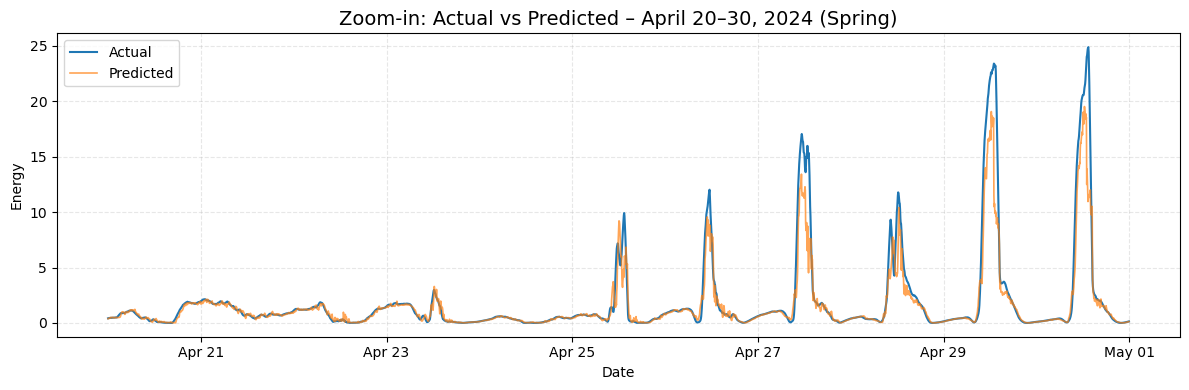

In [8]:
plot_zoom_april(YEAR2, final_model, features, target)


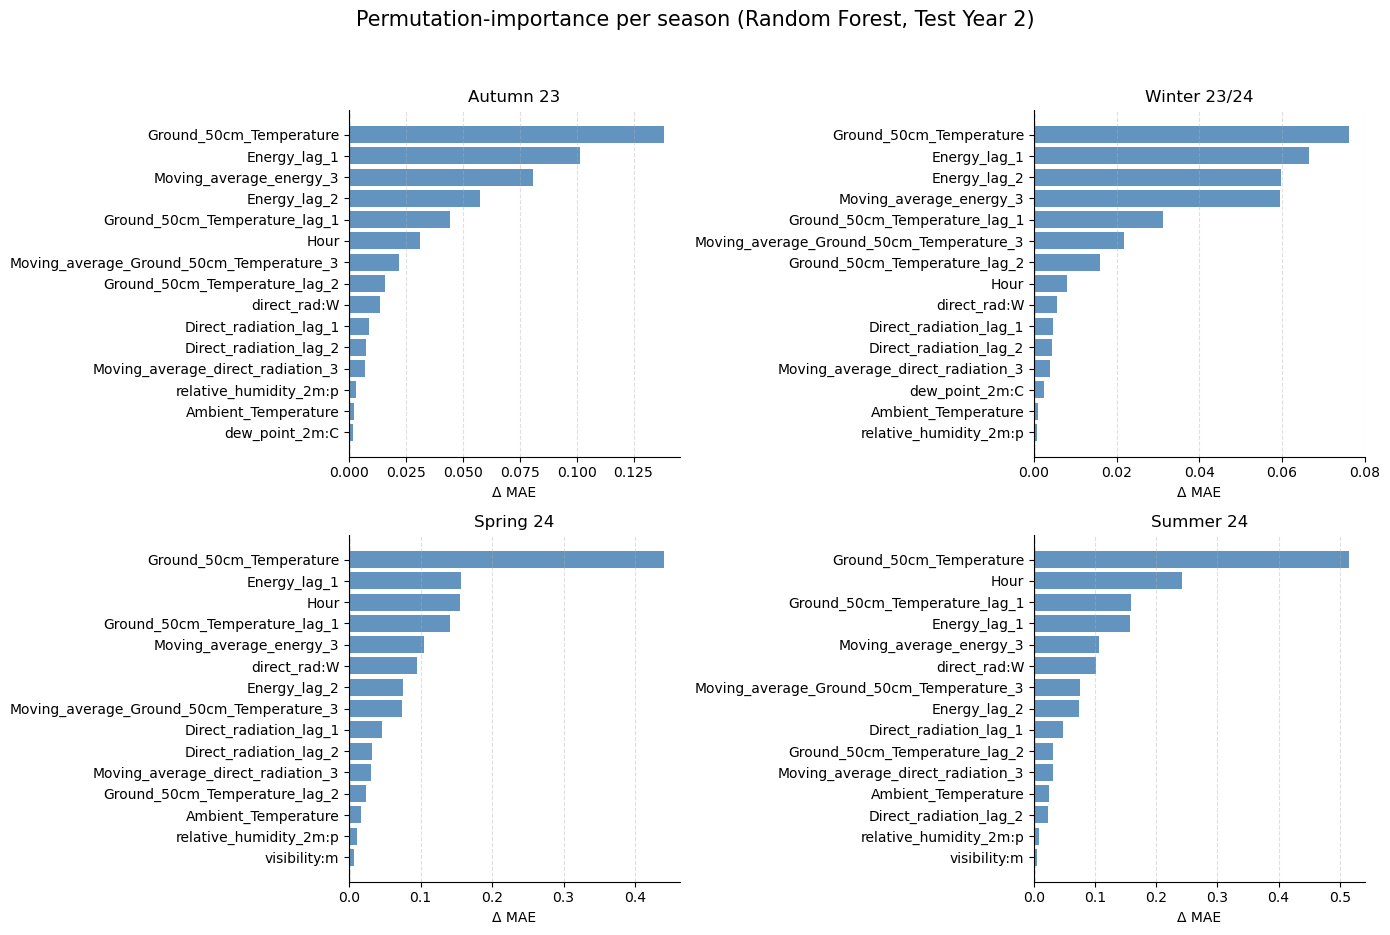

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.inspection import permutation_importance


# 1. Feature Importance DataFrame 
def importance_df(model, X, y, k=15, repeats=10):
    imp = permutation_importance(
        model, X, y,
        scoring="neg_mean_absolute_error",
        n_repeats=repeats, random_state=42, n_jobs=-1
    )
    delta = imp.importances_mean                    
    order = np.argsort(np.abs(delta))[::-1][:k]    

    df_imp = pd.DataFrame({
        "feature": X.columns[order],
        "delta_mae": delta[order]
    }).sort_values("delta_mae")  

    return df_imp

# 2. Engelse seizoen-blokken en subplot-grid
season_blocks_en = [
    ("Autumn 23",  "2023-10-01", "2023-11-30"),
    ("Winter 23/24","2023-12-01", "2024-02-29"),
    ("Spring 24",  "2024-03-01", "2024-05-31"),
    ("Summer 24",  "2024-06-01", "2024-08-31"),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False)
axes = axes.ravel()

for ax, (title, d1, d2) in zip(axes, season_blocks_en):
    blk = YEAR2.loc[d1:d2]
    if blk.empty:
        ax.axis("off")
        ax.set_title(f"{title}\n(no data)")
        continue

    imp_df = importance_df(final_model, blk[features], blk[target], k=15, repeats=10)

    colors = ["indianred" if x < 0 else "steelblue" for x in imp_df["delta_mae"]]

    
    ax.barh(imp_df["feature"], imp_df["delta_mae"], color=colors, alpha=0.85)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Δ MAE")

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.axvline(0, color="gray", linestyle="--", linewidth=1)
    ax.grid(axis="x", linestyle="--", alpha=0.4)

plt.suptitle("Permutation-importance per season (Random Forest, Test Year 2)", fontsize=15, y=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


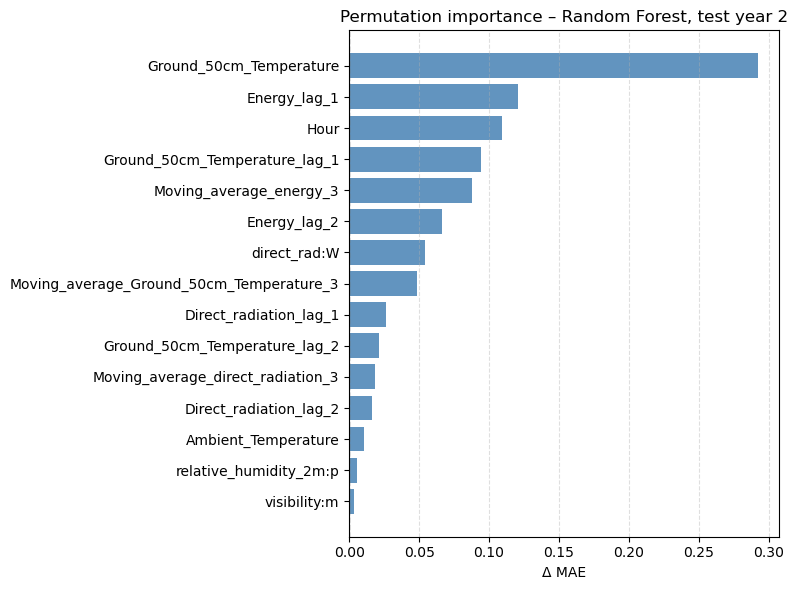

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

def imp_one_block(model, X, y, repeats=10):
    imp = permutation_importance(
        model, X, y,
        scoring="neg_mean_absolute_error",
        n_repeats=repeats,
        random_state=42,
        n_jobs=-1
    )
    return imp.importances_mean  


season_blocks_en = [
    ("Autumn 23",  "2023-10-01", "2023-11-30"),
    ("Winter 23/24","2023-12-01", "2024-02-29"),
    ("Spring 24",  "2024-03-01", "2024-05-31"),
    ("Summer 24",  "2024-06-01", "2024-08-31"),
]

impact_dict = {f: [] for f in features}

for _, d1, d2 in season_blocks_en:
    blk = YEAR2.loc[d1:d2]
    if blk.empty:
        continue
    delta_mae = imp_one_block(final_model, blk[features], blk[target])
    for f, imp_val in zip(features, delta_mae):
        impact_dict[f].append(imp_val)

avg_imp = {f: np.mean(v) for f, v in impact_dict.items() if v}
imp_series = pd.Series(avg_imp)


top_imp = imp_series.reindex(
    imp_series.abs().sort_values(ascending=False).index
).head(15).sort_values()


colors = ["indianred" if v < 0 else "steelblue" for v in top_imp]

plt.figure(figsize=(8, 6))
plt.barh(top_imp.index, top_imp.values, color=colors, alpha=0.85)
plt.axvline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Δ MAE")
plt.title("Permutation importance – Random Forest, test year 2")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np, pandas as pd, math, warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings("ignore")


# 1. Forecast horizons 
horizons = {
    "30minutes":  (5, 6),
    "1hour":      (11, 12),
    "6hours":     (66, 72),
    "12hours":    (132, 144),
    "24hours":    (264, 288)
}

for label, (shift_n, roll_n) in horizons.items():
    df[f"Energy_sum_target_{label}"] = (
        df["Energy (J)"].shift(-shift_n).rolling(window=roll_n, min_periods=roll_n).sum()
    )

# 2. Features
features = [
    "direct_rad:W","Direct_radiation_lag_1","Direct_radiation_lag_2",
    "Moving_average_direct_radiation_3",
    "Ground_50cm_Temperature","Ground_50cm_Temperature_lag_1",
    "Ground_50cm_Temperature_lag_2","Moving_average_Ground_50cm_Temperature_3",
    "Ambient_Temperature",
    "Energy_lag_1","Energy_lag_2","Moving_average_energy_3",
    "Hour","Month",

    "precip_5min:mm",
    "dew_point_2m:C",
    "relative_humidity_2m:p",
    "visibility:m",
    "wind_dir_10m:d",
    "wind_speed_10m:ms",
    "sfc_pressure:Pa"
]


# 3. Seizoensblokken
season_blocks = [
    ("Herfst 23",   "2023-10-01", "2023-11-30"),
    ("Winter 23/24","2023-12-01", "2024-02-29"),
    ("Lente 24",    "2024-03-01", "2024-05-31"),
    ("Zomer 24",    "2024-06-01", "2024-08-31"),
]


# 4. Vaste Random Forest hyperparameters 
best_params_rf = {
    "n_estimators": 60,
    "max_depth": 20,
    "min_samples_split": 6,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "random_state": 42,
    "n_jobs": -1
}

results = {}

# 5. Evaluatie per horizon
def metr(y_true, y_pred):
    return (
        mean_absolute_error(y_true, y_pred),
        math.sqrt(mean_squared_error(y_true, y_pred)),
        r2_score(y_true, y_pred)
    )

for label in horizons:
    print(f"\n🌲 Random Forest – Voorspelhorizon: {label}")
    target = f"Energy_sum_target_{label}"

    # Train/val splits
    split_ix = int(len(YEAR1) * 0.8)
    train_df = YEAR1.iloc[:split_ix]
    val_df   = YEAR1.iloc[split_ix:]

    X_train, y_train = train_df[features], train_df[target]
    X_val  , y_val   = val_df[features] , val_df[target]

    # Model pipeline
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestRegressor(**best_params_rf))
    ])

    model = pipe.fit(X_train, y_train)

    mae_tr, rmse_tr, r2_tr = metr(y_train, model.predict(X_train))
    mae_v , rmse_v , r2_v  = metr(y_val,   model.predict(X_val))

    print(f"  TRAIN   MAE {mae_tr:.3f} | RMSE {rmse_tr:.3f} | R² {r2_tr:.3f}")
    print(f"  VAL     MAE {mae_v :.3f} | RMSE {rmse_v :.3f} | R² {r2_v :.3f}")

    # Definitief model trainen op heel jaar 1
    final_model = pipe.fit(YEAR1[features], YEAR1[target])

    # Seizoens-evaluatie
    print(f"  Seizoensscores (jaar 2)")
    season_mae, season_rmse, season_r2 = [], [], []

    for name, d1, d2 in season_blocks:
        block = YEAR2.loc[d1:d2]
        if block.empty:
            print(f"    {name:10s} – geen rijen")
            continue

        y_true = block[target]
        y_pred = final_model.predict(block[features])

        mae, rmse, r2 = metr(y_true, y_pred)
        season_mae.append(mae)
        season_rmse.append(rmse)
        season_r2.append(r2)

        print(f"    {name:10s}  MAE {mae:.3f} | RMSE {rmse:.3f} | R² {r2:.3f}")

    results[label] = {
        "train_mae": mae_tr,
        "train_rmse": rmse_tr,
        "train_r2": r2_tr,

        "val_mae": mae_v,
        "val_rmse": rmse_v,
        "val_r2": r2_v,

        "test_mae": np.mean(season_mae),
        "test_rmse": np.mean(season_rmse),
        "test_r2": np.mean(season_r2),

        "model": final_model
    }


# 6. Samenvattende tabel
print("\n📊 Samenvatting per horizon (Random Forest):")

summary = pd.DataFrame([
    {
        "Horizon": k,
        "Train MAE": v["train_mae"],
        "Train RMSE": v["train_rmse"],
        "Train R²": v["train_r2"],

        "Val MAE": v["val_mae"],
        "Val RMSE": v["val_rmse"],
        "Val R²": v["val_r2"],

        "Test MAE": v["test_mae"],
        "Test RMSE": v["test_rmse"],
        "Test R²": v["test_r2"],
    }
    for k, v in results.items()
])

print(summary.round(3))



🌲 Random Forest – Voorspelhorizon: 30minutes
  TRAIN   MAE 0.028 | RMSE 0.105 | R² 0.990
  VAL     MAE 0.113 | RMSE 0.361 | R² 0.947
  Seizoensscores (jaar 2)
    Herfst 23   MAE 0.041 | RMSE 0.108 | R² 0.935
    Winter 23/24  MAE 0.018 | RMSE 0.068 | R² 0.920
    Lente 24    MAE 0.120 | RMSE 0.410 | R² 0.930
    Zomer 24    MAE 0.138 | RMSE 0.423 | R² 0.941

🌲 Random Forest – Voorspelhorizon: 1hour
  TRAIN   MAE 0.068 | RMSE 0.219 | R² 0.989
  VAL     MAE 0.311 | RMSE 0.923 | R² 0.910
  Seizoensscores (jaar 2)
    Herfst 23   MAE 0.115 | RMSE 0.261 | R² 0.898
    Winter 23/24  MAE 0.055 | RMSE 0.175 | R² 0.863
    Lente 24    MAE 0.332 | RMSE 1.062 | R² 0.876
    Zomer 24    MAE 0.392 | RMSE 1.123 | R² 0.892

🌲 Random Forest – Voorspelhorizon: 6hours
  TRAIN   MAE 0.391 | RMSE 0.883 | R² 0.991
  VAL     MAE 3.397 | RMSE 6.593 | R² 0.746
  Seizoensscores (jaar 2)
    Herfst 23   MAE 1.440 | RMSE 2.117 | R² 0.679
    Winter 23/24  MAE 0.782 | RMSE 1.303 | R² 0.660
    Lente 24    MAE 3


📈 Permutation importance – Horizon: 30minutes

📈 Permutation importance – Horizon: 1hour

📈 Permutation importance – Horizon: 6hours

📈 Permutation importance – Horizon: 12hours

📈 Permutation importance – Horizon: 24hours


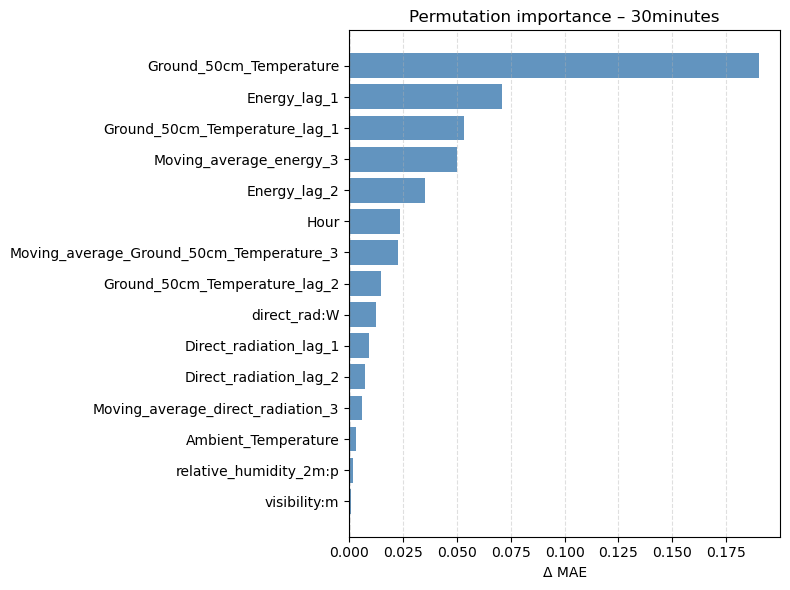

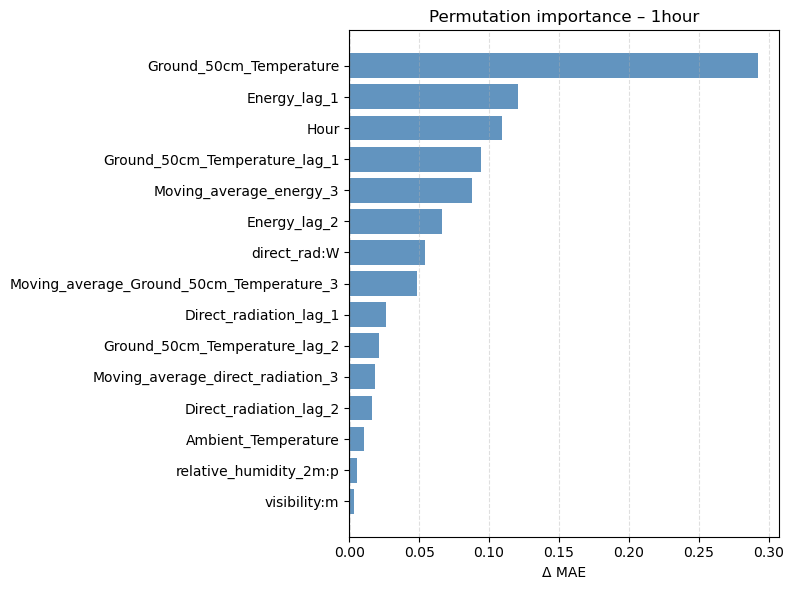

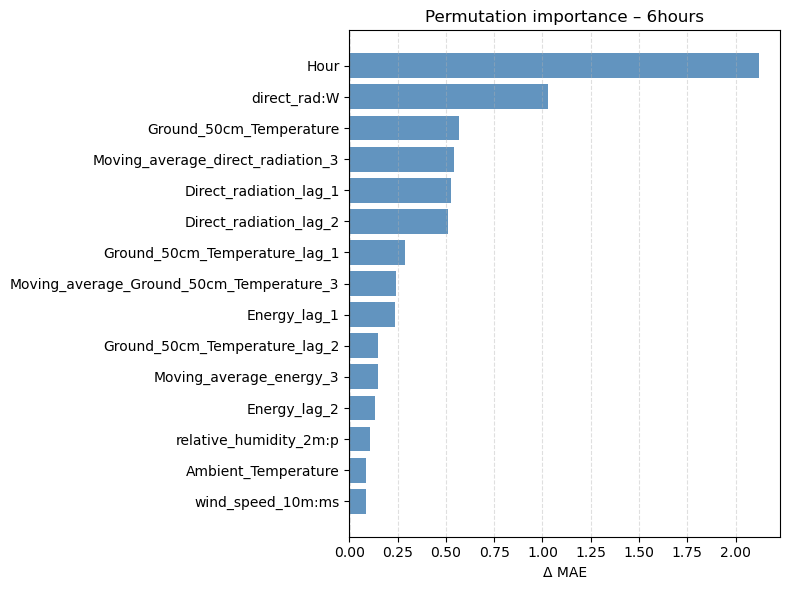

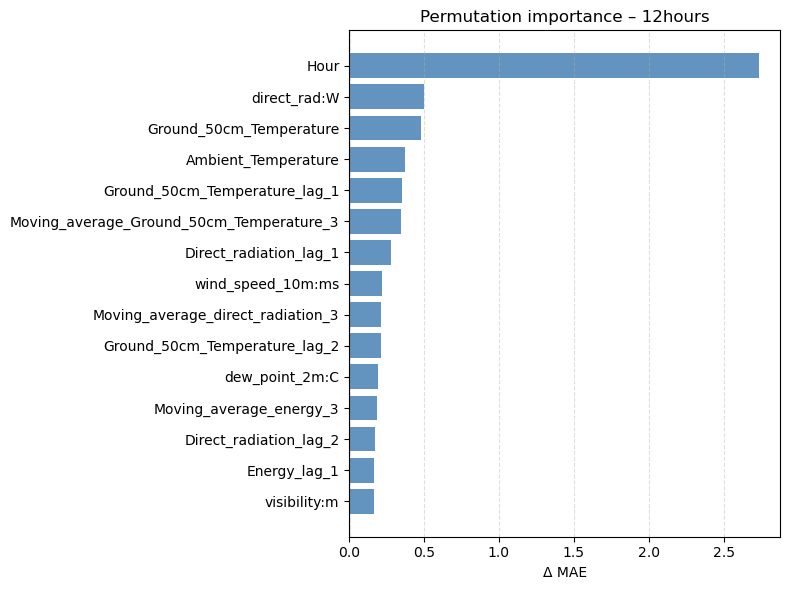

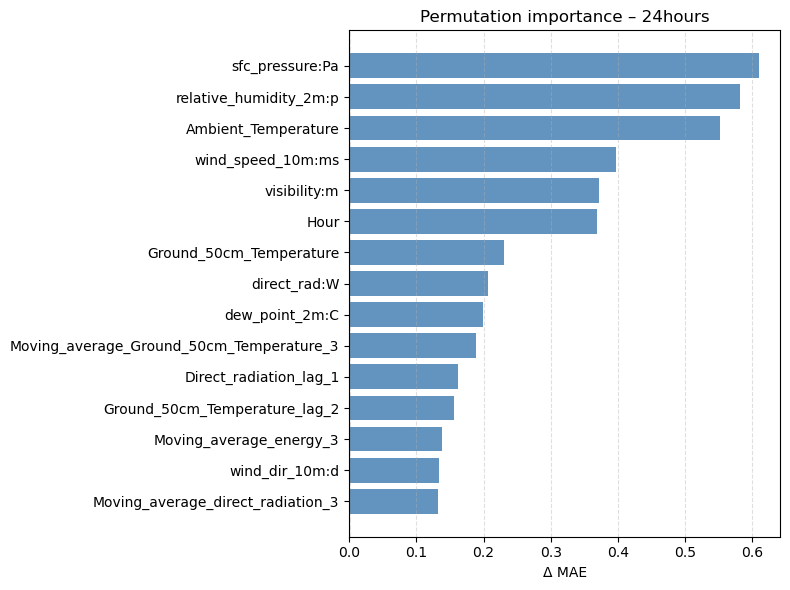

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

def imp_one_block(model, X, y, repeats=10):
    imp = permutation_importance(
        model, X, y,
        scoring="neg_mean_absolute_error",
        n_repeats=repeats,
        random_state=42,
        n_jobs=-1
    )
    return imp.importances_mean  

season_blocks_en = [
    ("Autumn 23",  "2023-10-01", "2023-11-30"),
    ("Winter 23/24","2023-12-01", "2024-02-29"),
    ("Spring 24",  "2024-03-01", "2024-05-31"),
    ("Summer 24",  "2024-06-01", "2024-08-31"),
]

importance_per_horizon = {}

for label in horizons:
    print(f"\n📈 Permutation importance – Horizon: {label}")
    model = results[label]["model"]
    target = f"Energy_sum_target_{label}"

    # Impact dictionary initialiseren
    impact_dict = {f: [] for f in features}

    for _, d1, d2 in season_blocks_en:
        blk = YEAR2.loc[d1:d2]
        if blk.empty:
            continue
        X_blk = blk[features]
        y_blk = blk[target]

        delta_mae = imp_one_block(model, X_blk, y_blk)
        for f, imp_val in zip(features, delta_mae):
            impact_dict[f].append(imp_val)

    # Gemiddelde ΔMAE per feature
    avg_imp = {f: np.mean(v) for f, v in impact_dict.items() if v}
    importance_per_horizon[label] = pd.Series(avg_imp).sort_values(key=abs, ascending=False)


for label, imp_series in importance_per_horizon.items():
    top_imp = imp_series.head(15).sort_values()
    colors = ["indianred" if v < 0 else "steelblue" for v in top_imp]

    plt.figure(figsize=(8, 6))
    plt.barh(top_imp.index, top_imp.values, color=colors, alpha=0.85)
    plt.axvline(0, color="gray", linestyle="--", linewidth=1)
    plt.xlabel("Δ MAE")
    plt.title(f"Permutation importance – {label}")
    plt.grid(axis="x", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


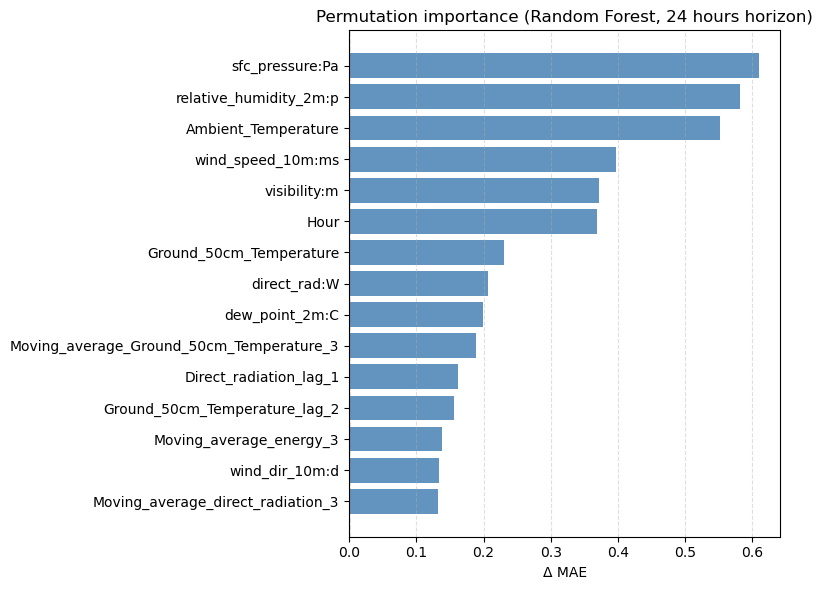

In [ ]:
import matplotlib.pyplot as plt

imp_series = importance_per_horizon["24hours"]

top_imp = imp_series.abs().sort_values(ascending=False).head(15)
top_imp = imp_series[top_imp.index].sort_values()  # behoud teken

colors = ["indianred" if v < 0 else "steelblue" for v in top_imp]

plt.figure(figsize=(8, 6))
plt.barh(top_imp.index, top_imp.values, color=colors, alpha=0.85)
plt.axvline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Δ MAE")
plt.title("Permutation importance (Random Forest, 24 hours horizon)")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
